In [ ]:
# Imports
import numpy as np
from numpy.lib.arraysetops import unique
from scipy.sparse import lil_matrix, csr_matrix, bmat
from scipy.sparse import linalg 
from scipy.sparse.linalg import spsolve

In [ ]:
# Import repository
! rm -fr * # delete all local files
! git clone https://gitlab.com/jan.zeman4/d32mhm2_en.git tmp 
! mv tmp/* . # copy to current directory
! rm -fr tmp/ # cleanup

Cloning into 'tmp'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 105 (delta 55), reused 99 (delta 49), pack-reused 0
Receiving objects: 100% (105/105), 180.29 KiB | 8.19 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
# Local functions
from show import show
from data import u_D_hmg 
from stima import f_int3_hmg_rhs_pwrlaw, stima3_hmg_rhs_pwrlaw

In [ ]:
# Load all data
coordinates = np.loadtxt ( 'coordinates_hmg_code.dat', comments = '%' )
elements3 = np.loadtxt( 'elements3_hmg.dat', dtype = 'int', comments = '%' )
dirichlet = np.loadtxt( 'dirichlet_hmg.dat', dtype = 'int', comments = '%' )

# New data needed for homogenization
phases = np.loadtxt ( 'phases_hmg_pwrlaw.dat', comments = '%' )
periodicity = np.loadtxt ( 'periodicity_hmg.dat', dtype = 'int', comments = '%' )
ID = coordinates[:, 3]
ID = ID.astype(int)

In [ ]:
# delete first columns from coordinates, elements3, elements4, and neumann arrays
coordinates = np.delete( coordinates, 3, 1 ) # last colum was stored in ID
coordinates = np.delete( coordinates, 0, 1 )
elements3 = np.delete( elements3, 0, 1 )
dirichlet = np.delete( dirichlet, 0, 1 )
phases = np.delete( phases, 0, 1 )
periodicity = np.delete( periodicity, 0, 1 )

In [ ]:
# Solution parameters of Newton method
tolerance = 1e-10
maxiter = 10

In [ ]:
# Setup matrice
ndof = max( ID ) + 1

K = lil_matrix( np.zeros( (ndof, ndof) ) )
f_int = np.zeros( (ndof, 1) )  
d = np.zeros( (ndof, 1) ) # Initial guess
dd = np.zeros( (ndof, 1) ) # Newton step
de = np.zeros( (3, 1) ) # Matrix of nodal temperature

In [ ]:
G = [ [0], [1] ]
d[...] = 0

# Newton method
for k in range( maxiter ):
  f_int[...] = 0

  for e in range( elements3.shape[0] ):
    IDe = ID[elements3[e, 0:3]] # Element code numbers 
    isIDe = IDe > -1 # Active code numbers

    de[...] = 0
    de[ isIDe ] = d[ IDe[ isIDe ]]

    f_int_e = f_int3_hmg_rhs_pwrlaw( coordinates[ elements3[e, 0:3], ], phases[ elements3[e, 3], ], de, G ) # element RHS
    f_int[ IDe[ isIDe ] ] += f_int_e[ isIDe ]
    
  norm = np.linalg.norm(f_int)
  print( "> Iteration = ", str(k), " norm = ", str(norm) )
    
  if( norm < tolerance ):
    break

  # Assemble tanget matrix
  K[...] = 0

  for e in range( elements3.shape[0] ):
    IDe = ID[elements3[e, 0:3]] # Element code numbers 
    isIDe = IDe > -1 # Active code numbers

    de[...] = 0
    de[ isIDe ] = d[IDe[ isIDe ]]

    Ke = stima3_hmg_rhs_pwrlaw( coordinates[ elements3[e, 0:3], ], phases[ elements3[e, 3], ], de, G ) # element RHS
    K[ np.ix_( IDe[ isIDe ], IDe[ isIDe ] ) ] += Ke[ np.ix_(isIDe, isIDe) ]
 
  # Solve for Newton step
  dd = spsolve( K.tocsr(), -f_int )
  d += dd.reshape(ndof, 1)

> Iteration =  0  norm =  0.0


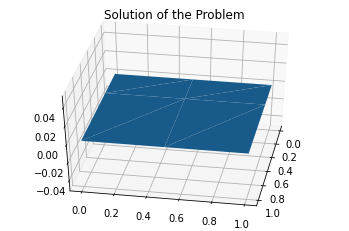

In [ ]:
d_plt = np.zeros( (coordinates.shape[0], 1 ) ) # Reshape solution for plotting
d_plt[ ID > -1 ] = d[ ID[ ID > -1 ] ] # Copy data

show(elements3[:, 0:3], np.array([]), coordinates, d_plt )